# 线性回归的从零开始实现

在了解了线性回归的背景知识之后，现在我们可以动手实现它了。尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此，本节将介绍如何只利用`Tensor`和`GradientTape`来实现一个线性回归的训练。
首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示。

In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import tensorflow as tf
import random

## 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征$\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重$\boldsymbol{w} = [2, -3.4]^\top$和偏差$b = 4.2$，以及一个随机噪声项$\epsilon$来生成标签

$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = tf.random.normal(stddev=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += tf.random.normal(stddev=0.01, shape=labels.shape)

注意，`features`的每一行是一个长度为2的向量，而`labels`的每一行是一个长度为1的向量（标量）。

In [3]:
features[0], labels[0]

(<tf.Tensor: id=31, shape=(2,), dtype=float32, numpy=array([ 0.01317476, -1.5601287 ], dtype=float32)>,
 <tf.Tensor: id=35, shape=(), dtype=float32, numpy=9.521702>)

通过生成第二个特征`features[:, 1]`和标签 `labels` 的散点图，可以更直观地观察两者间的线性关系。

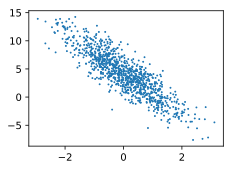

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);



## 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = min(i + batch_size, num_examples)
        yield features[i:j], labels[i:j]

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tf.Tensor(
[[ 0.01317476 -1.5601287 ]
 [-1.5447617   0.8646286 ]
 [-0.69407433  0.5979207 ]
 [-1.3370134   0.06325391]
 [-0.3141921   1.259486  ]
 [ 0.48622438  0.78185797]
 [ 0.08360149 -0.7971149 ]
 [ 0.23262888 -0.9619031 ]
 [ 0.97124684 -0.8057955 ]
 [ 0.58449775 -0.01893086]], shape=(10, 2), dtype=float32) tf.Tensor(
[ 9.521702  -1.8393052  0.7744466  1.3168004 -0.698446   2.5151038
  7.069128   7.93736    8.877049   5.420314 ], shape=(10,), dtype=float32)


## 定义模型


In [7]:
class LrModel:
    def __init__(self):
        self.w = tf.Variable(tf.random.normal(stddev=0.01, shape=(num_inputs, 1)))
        self.b = tf.Variable(tf.zeros(shape=(1,)))
        
    def __call__(self, X): 
        return tf.matmul(X, self.w) + self.b

## 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [8]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh包中方便以后使用
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

## 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用`gradient`计算小批量随机梯度，并用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [9]:
lr = 0.03
num_epochs = 3
model = LrModel()
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as t:
            l = loss(model(X), y)  # l是有关小批量X和y的损失
        dw, db = t.gradient(l, [model.w, model.b]) # 小批量的损失对模型参数求梯度
        model.w.assign_sub(lr * dw / batch_size)
        model.b.assign_sub(lr * db / batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(model(features), labels)
    print('epoch %d, loss %f' % (epoch + 1, tf.reduce_mean(train_l).numpy()))

epoch 1, loss 0.041898
epoch 2, loss 0.000163
epoch 3, loss 0.000051


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [10]:
true_w, model.w

([2, -3.4], <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 1.9996991],
        [-3.3989727]], dtype=float32)>)

In [11]:
true_b, model.b

(4.2,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.199808], dtype=float32)>)